In [1]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing Libraries
import librosa  
import numpy as np  
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib


In [3]:
def extract_features(audio_path):
    # Loading the audio files
    data, sample_rate = librosa.load(audio_path, res_type='kaiser_fast')
    
    # Extracting features from the audio files
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)

    chroma_stft = np.mean(librosa.feature.chroma_stft(y=data, sr=sample_rate).T, axis=0)

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)

    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)

    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)

    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    
    poly_features = np.mean(librosa.feature.poly_features(y=data, sr=sample_rate).T, axis=0)

    # Horizontally stacking features
    features = np.hstack([zcr, chroma_stft, mfcc, rms, mel_spectrogram, spectral_contrast, tonnetz, spectral_rolloff, poly_features])

    return features

In [4]:
# Defining the features and labels
X = []
Y = []
base_dir = os.getcwd()
dataset_dir = os.path.join(base_dir, 'filtered_dataset')
emotion_list = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']

In [5]:
# Extracting features
total_files = sum([len(files) for r, d, files in os.walk(dataset_dir)])
pbar = tqdm(total=total_files)

for emotion in emotion_list:
    emotion_dir = os.path.join(dataset_dir, emotion)
    for file in os.listdir(emotion_dir):
        if file.endswith('.wav'):
            audio_path = os.path.join(emotion_dir, file)
            features = extract_features(audio_path)
            X.append(features)
            Y.append(emotion)
            pbar.update()

pbar.close()

100%|██████████| 8391/8391 [31:39<00:00,  4.42it/s]


In [6]:
# Saving Features and Labels
np.save('saved_features/data.npy', X)
np.save('saved_features/labels.npy', Y)

In [7]:

# Importing saved features
X = np.load('saved_features/data.npy')
Y = np.load('saved_features/labels.npy')

# Converting to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Label Encoding
lr = LabelEncoder()
Y_enc = lr.fit_transform(Y)

# Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_enc, test_size=0.3, random_state=48)   


In [19]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # fit_transform on training data and transform on testing data to avoid data leakage
X_test_scaled = scaler.transform(X_test)

In [28]:
# Checking the encoded labels
for index, label in enumerate(lr.classes_):
    print(f'{index}: {label}')

0: Angry
1: Disgusted
2: Fearful
3: Happy
4: Neutral
5: Sad
6: Surprised


In [29]:
# Building the model
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [30]:
# Defining the checkpoint path and compiling the model
checkpoint_path = 'saved_model/model.keras'
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min') 

In [31]:
# Training the model
history = model.fit(X_train_scaled, Y_train, validation_data=(X_test_scaled, Y_test), epochs=100, batch_size=32, callbacks=[cp_callback])

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3651 - loss: 1.9054
Epoch 1: val_loss improved from inf to 2.05456, saving model to saved_model/model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3655 - loss: 1.9038 - val_accuracy: 0.2621 - val_loss: 2.0546
Epoch 2/100
179/184 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5162 - loss: 1.3055
Epoch 2: val_loss improved from 2.05456 to 1.48701, saving model to saved_model/model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5165 - loss: 1.3051 - val_accuracy: 0.4095 - val_loss: 1.4870
Epoch 3/100
179/184 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5497 - loss: 1.1735
Epoch 3: val_loss improved from 1.48701 to 1.04205, saving model to saved_model/model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5503 - loss: 1.1723 - val_accuracy: 0.5941 - val_loss: 1.0420
Epoch 4/100
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5838 - loss: 1.0840
Epoch 4: val_loss impro

In [36]:
# Evaluating the model
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print(f'The loss on the test set is {loss:.2f} and the accuracy is {accuracy:.2f}')

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7150 - loss: 0.8878
The loss on the test set is 0.89 and the accuracy is 0.72


In [ ]:
# Generating the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test_scaled)
Y_pred_classes = np.argmax(Y_pred, axis=-1)  # operating along the last axis i.e. the columns to get the index of the maximum value

cm = confusion_matrix(Y_test, Y_pred_classes)  

# Fetching class names from the encoder
class_names = lr.classes_

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')

# Add labels to the plot
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

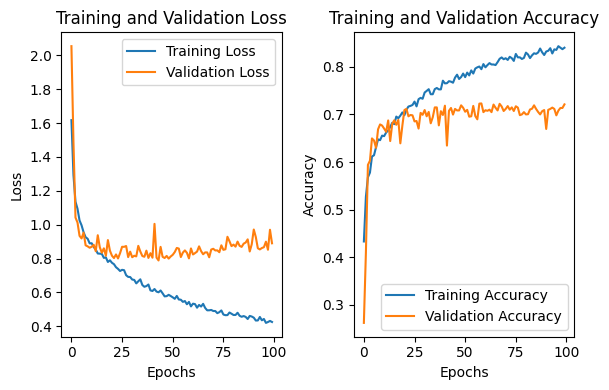

In [47]:
# Visualizing the training history
import matplotlib.pyplot as plt

# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

# Plotting training loss and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plotting training accuracy and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
plt.tight_layout()

plt.show()

In [68]:
# Saving the scaler for future detection use
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']